In [1]:
using PyPlot, Korg

[ Info: Precompiling Korg [acafc109-a718-429c-b0e5-afd7f8c7ae46]


# read solar atlas

In [3]:
using DelimitedFiles

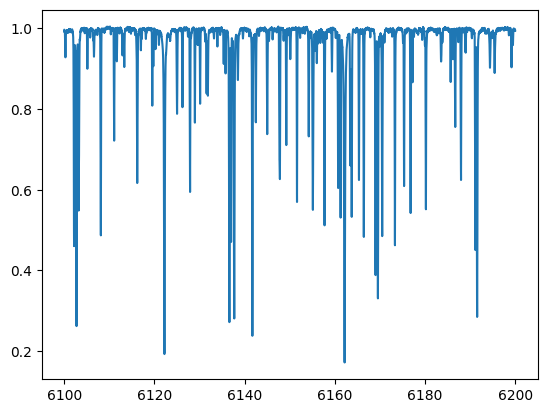

In [9]:
hinkel = readdlm("hinkel-solar-atlas.txt"; skipstart=17)
wlmask = 6100 .<= hinkel[:, 2] .<= 6200
solar_wls = hinkel[wlmask, 2]
solar_rect_flux = hinkel[wlmask, 3]
plot(solar_wls, solar_rect_flux);

In [8]:
?find_best_fit_params

search: find_best_fit_params



```
find_best_fit_params(obs_wls, obs_flux, obs_err, linelist, initial_guesses, fixed_params; kwargs...)
```

!!! warning
    This is in beta. It's API may change.  Use at your own risk.


Find the parameters and abundances that best match a rectified observed spectrum.

# Arguments:

  * `obs_wls`: the wavelengths of the observed spectrum in Å
  * `obs_flux`: the rectified flux of the observed spectrum
  * `obs_err`: uncertainty in `flux`
  * `linelist`: a linelist to use for the synthesis
  * `initial_guesses`: a NamedTuple specifying initial guesses for the parameters to be fit.  See  "Specifying parameters" below.
  * `fixed_params`: a NamedTuple specifying parameters to be held fixed. See "Specifying parameters"  below.

`initial_guesses` and `fixed_params` can also be specified as Dicts instead of NamedTuples, which is  more convienient when calling Korg from python.

# Specifying parameters

Parameters are specified as NamedTuples, which look like this: `(Teff=5000, logg=4.5, m_H=0.0)`. Single-element NamedTuples require a semicolon: `(; Teff=5000)`. 

## Required parameters

`Teff` and `logg` *must* be specified in either `initial_guesses` or `fixed_params`.

## Optional Parameters

These can be specified in either `initial_guesses` or `fixed_params`, but if they are not default  values are used.

  * `m_H`: the metallicity of the star, in dex. Default: `0.0`
  * `vmic`: the microturbulence velocity, in km/s. Default: `1.0`
  * `vsini`: the projected rotational velocity of the star, in km/s. Default: `0.0`.   See [`Korg.apply_rotation`](@ref) for details.
  * `epsilon`: the linear limb-darkening coefficient. Default: `0.6`. Used for applying rotational  broadening only.  See [`Korg.apply_rotation`](@ref) for details.
  * Individual elements, e.g. `Na`, specify the solar-relative ([X/H]) abundance of that element.

!!! tip
    If you are doing more than a few fits, you will save a lot of time by precomputing the LSF  matrix and synthesis wavelengths.  See the keyword arguments below for how to do that.


# Keyword arguments

  * `windows` (optional) is a vector of wavelength pairs, each of which specifies a wavelength  "window" to synthesize and contribute to the total χ². If not specified, the entire spectrum is  used. Overlapping windows are automatically merged.
  * `LSF_matrix` (optional) is a matrix which maps the synthesized spectrum to the observed spectrum.  If not specified, it is calculated using `Korg.compute_LSF_matrix`.  Computing the LSF matrix can  be expensive, so you may want to precompute it if you are fitting many spectra with the same LSF.
  * `synthesis_wls`: a superset of the wavelengths to synthesize, as a range.  If not specified,   wavelengths spanning the first and last windows are used. If you pass in a precomputed   LSF matrix, you must make sure that the synthesis wavelengths match it.
  * `wl_buffer` is the number of Å to add to each side of the synthesis range for each window.
  * `precision` specifies the tolerance for the solver to accept a solution. The solver operates on   transformed parameters, so `precision` doesn't translate straitforwardly to Teff, logg, etc, but   the default is, `1e-3`, provides a worst-case tolerance of about 1.5K in `Teff`, 0.002 in `logg`,   0.001 in `m_H`, and 0.004 in detailed abundances.

# Returns

A NamedTuple with the following fields:

  * `best_fit_params`: the best-fit parameters
  * `best_fit_flux`: the best-fit flux, with LSF applied, resampled, and rectified.
  * `obs_wl_mask`: a bitmask for `obs_wls` which selects the wavelengths used in the fit (i.e. those  in the `windows`)
  * `solver_result`: the result object from `Optim.jl`
  * `trace`: a vector of NamedTuples, each of which contains the parameters at each step of the  optimization.
